In [1]:
#Functions are explained

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,callbacks
import numpy as np
import os
import random
import math
import gc
import tensorflow.keras.backend as K
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

#All functions...
# Define the custom sigmoid function
def custom_sigmoid(x):
    """
    The purpose of defining a custom sigmoid function is to turn sigmoid fucntion into a function by which 
    class memberships are represented more linearly. 
    why ?: because if we work with logistic functions, even the slightest change cause a dramatical change 
    in the output. We dont want that kind of fragile models.
    why not RELU: because relu is not bounded between (0,1).
    The parameter 'sigmoid_softening_coeff' determines the rate of linearity. We can make the output 
    more linear by increasing this coefficient. But there is no need to flood the memory with big numbers.
    """
    if sigmoid_softener==True:
        return 1 / (1 + tf.exp(-x/sigmoid_softening_coeff))
    else:
        return 1 / (1 + tf.exp(-x))
    
# Create the model
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(28, 28,1)),
        
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(size_of_walsh, activation=custom_sigmoid)
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


def assign_to_new_classes(predicted_results,my_walsh_vectors):
    """ 
    we need this function in the evaluation phase. In the evaluation phase, after we obtain the output representation
    for one sample, we calculate the distance between the obtained representation and previously assigned class representations.
    each distance is calculated with respect to the 'Binary Cross Entropy loss- BCE'. 
    Because we used BCE in the model, we had to use it in class assignments as well 
    
    Note: When a new class is fed to the model, we keep track of which vector representation was given to that class.
    that procedure is further explained in 'determine_walsh_vectors_as_output_labels' function. 
    
    
    """
    num_results=predicted_results.shape[0]
    new_results=predicted_results.copy()
    for i in range(num_results):
        current_prediction=predicted_results[i,:]
        distances_to_vectors=[np.linalg.norm(current_prediction-my_vector) for my_vector in my_walsh_vectors]
        minimum_dist_value=np.min(distances_to_vectors)
        minimum_dist_ind=np.where(distances_to_vectors==minimum_dist_value)
        my_index=minimum_dist_ind[0]
        my_index=int(my_index[0])
        new_prediction=my_walsh_vectors[my_index]
        new_results[i,:]=new_prediction
    return new_results

def create_score(x,y):
    #Score is based on accuracy. 
    #Accuracy= true predictions/all predictions
    successful_pred=0
    for i in range(x.shape[0]):
        if (x[i,:]==y[i,:]).all():
            successful_pred+=1
    score=successful_pred/x.shape[0]
    return score        
#create Walsh
def create_walsh(size_of_walsh):
    # this fumction gives you a matrix whose rows are the vectors that can be used to represent classes. 
    #walsh vector representations allow classes to share some features. It is our best bet against class incremental learning. 
    #because previous tasks dynamically create features that can be exploited by future tasks. 
    size_of_walsh=int(math.log(size_of_walsh,2)+1)#2^n=size->>> n=log(size,2)
    j=1
    W_old=1
    for i in range(size_of_walsh):
        j_new=2**i
        W_new=np.zeros([j_new,j_new], dtype=np.float32)
        W_new[:j,:j]=W_old
        W_new[j:,:j]=W_old
        W_new[:j,j:]=W_old
        W_new[j:,j:]=abs(1-W_old)
        W_old=W_new
        j=j_new
    return W_new

def calculate_bce_dist(y_train_i_predicted_mean, walsh_vec):
    #we used Binary cross entropy in the model. So we will have to use it for class assignments as well.
    #For the sake of consistency
    epsilon = 1e-15  # Small value to prevent division by zero
    loss_calc = - (y_train_i_predicted_mean * np.log(custom_sigmoid(walsh_vec + epsilon)) + (1 - y_train_i_predicted_mean) * np.log(1 - custom_sigmoid(walsh_vec + epsilon)))
    caclulated_dist = np.mean(loss_calc)
    return caclulated_dist

def find_optimal_negotiation_plasticity_rate(neg):
    """
    Lets derive the formula below:
    We will consecutively allocate model's capacity to the tasks. But we have to make sure that each task uses the same amount.
    Lets give an example
    negotiation_rate=n=0.8
    model's capacity that is allocated to the first task is 20 percent. 
    if we don't change negotiation rate,
    model's capacity that is allocated to the second task will also be 20 percent.
    But model's capacity that is allocated to the first task will decrease and become 16 percent. 
    Because 20 percent of 20 percent is equal to 4 percent. 
    so, we want to update the negotiation rate in such a way that ensures equal capacity allocation for each task. 
    
    (1-n)*m=1-m
    2*m=1-m*n
    m(2+n)=1
    m=1/(2+n)
    the variable m denotes the new negotiation rate.
    but we are trying to find a new variable which will be multiplied with n yielding to the new negotiation rate m. 
    new variable= m/n
    
    new variable=1/(2*n+n*n)
    
    new variable=1/(2*n+n^2)
    
    it can be seen that the formula below is exactly the same.
    you should look at the line where this function is called. The explanation will make more sense. 
    
    
    """
    return 1/(2*neg-neg**2)

def determine_walsh_vectors_as_output_labels(domain_model,x_train, y_train, available_representations):
    """
    Expalanion:
    In class incremental learning;
    when we come across to a new class, we assign a class representative vector to that class. 
    We must select a class representative vector among the vectors that are not used. 
    For this purpose, we define a list called 'available_representations'.
    We make sure that we don't use any of the vectors that are previously used for representing another class. 
    
    In order to better exploit the model we first calculate output representations of all samples. 
    We then calculate the distances of all outputs to each available representation.
    We then take the mean of the distances, so that we can compare all the mean values and 
    decide which representation is the closest, therefore the best, candidate for representing the new class. 
    we select the closest vector as a class representative update its index 'available_representations' to FALSE
    by updating that index, we make sure that the selected index won't be used as the class representative for another class. 
    
    """
    
    
    y_train_matrix= np.full((x_train.shape[0],size_of_walsh),walsh_vector_list[0,:])
    for i in np.unique(y_train):
        x_train_i = x_train[y_train == i][:]        
        # Compute the model prediction for this class and take the mean
        y_train_i_predicted_mean = domain_model.predict(x_train_i).mean(axis=0)
        # Initialize the closest vector to be None
        closest_vector = None
        closest_vector_index = None
        min_distance = np.inf

        # For each walsh vector, find the closest available walsh vector
        for j, walsh_vec in enumerate(walsh_vector_list):
            #if the best representation is not available try the next best until you hit an available representation. 
            if available_representations[j]:
                
                #dist = np.linalg.norm(y_train_i_predicted_mean - walsh_vec)
                dist = calculate_bce_dist(y_train_i_predicted_mean, walsh_vec)
                if dist < min_distance:
                    min_distance = dist
                    closest_vector = walsh_vec
                    closest_vector_index = j

        # If no vector is found, then all vectors have been assigned
        if closest_vector is None:
            raise Exception('All vectors have been assigned, we cannot assign new one for class ', i)

        # Mark the vector as assigned
        available_representations[closest_vector_index] = False

        # Update the train matrix
        y_train_matrix[y_train == i,:]= closest_vector
    return y_train_matrix, available_representations


average_of_all_seeds_list=[]
initial_negotiation_rate_list=[]
for initial_negotiation_rate in range(1,99):

    #Experiments....
    acc_lists=[]# average accuracies belonging to each seed are stored in here.
    for my_seed in range(5):
        #we do the experiments with different seed values. Just to make sure the results are not accidental. 
        # we can also use this setup to make sure the variance is not high.
        #which means that the accuracy should not change very much by changing the seed. 
        os.environ['PYTHONHASHSEED']=str(1)
        tf.random.set_seed(my_seed)
        np.random.seed(my_seed)
        random.seed(my_seed)
        #settings
        sigmoid_softener=True
        sigmoid_softening_coeff=3# linearization coefficient of the sigmoid function. 
        negotiation_rate=initial_negotiation_rate*0.01 #initial negotiation rate.
        initial_negotiation_rate_list.append(negotiation_rate)
        batch_size = 128
        size_of_walsh=16#size of each walsh vector. 
        epochs = 5#number of epochs
        num_classes=10#MNist Data

        #Divnet related functions
        x_train_class = []
        x_test_class = []
        y_test_class = []
        y_train_class = []
        scores_list=[]
        selected_vectors=[]
        x_train_classes=[]
        y_train_classes=[]
        x_test_classes=[]
        y_test_classes=[]

        y_train_map_list=[]
        class_pairs = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]

        # Load the MNIST dataset
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        # Make sure images have shape (28, 28, 1)
        #y_train, y_test = y_train.flatten(), y_test.flatten()

        # Normalize the data
        x_train = x_train.astype('float32') / 255
        x_test = x_test.astype('float32') / 255
        possible_assignments=[]
        # Walsh vector encoding
        walsh_vector_list=create_walsh(size_of_walsh)#the matrix the rows of which will be selected as vector representations. 

        #print("walsh_vector_list.shape",walsh_vector_list.shape)
        available_representations=[True] * size_of_walsh


        # Main loop
        model = create_model()
        x_test_pairs=[]
        y_test_pairs=[]
        for i, class_pair in enumerate(class_pairs):
            #print(f"Training on class pair {class_pair}")
            for my_class in class_pair:
                #print("My class: ",my_class)
                x_train_my_class=x_train[y_train==my_class,:,:]
                y_train_my_class=y_train[y_train==my_class]
                x_test_my_class=x_test[y_test==my_class,:,:]
                y_test_my_class=y_test[y_test==my_class]
                # Assign each label in y_train and y_test to its corresponding 1xsize_of_walsh vector in the matrix

                y_train_my_class_mapped, available_representations = determine_walsh_vectors_as_output_labels(model,x_train_my_class,y_train_my_class, available_representations)
                y_test_my_class_mapped = np.full((x_test_my_class.shape[0],size_of_walsh),y_train_my_class_mapped[0,:])
                possible_assignments.append(np.unique(y_train_my_class_mapped,axis=0))
                x_train_classes.append(x_train_my_class)
                y_train_classes.append(y_train_my_class_mapped)
                x_test_classes.append(x_test_my_class)
                y_test_classes.append(y_test_my_class_mapped)  

            x_train_pair=np.concatenate((x_train_classes[-1],x_train_classes[-2]),axis=0)
            y_train_pair=np.concatenate((y_train_classes[-1],y_train_classes[-2]),axis=0)
            x_test_pair=np.concatenate((x_test_classes[-1],x_test_classes[-2]),axis=0)
            y_test_pair=np.concatenate((y_test_classes[-1],y_test_classes[-2]),axis=0)
            y_pred = model.predict(x_train_pair)
            # Negotiate with the past experiences in order to not forget previous tasks. 
            y_train_pair=y_train_pair*(1-negotiation_rate)+y_pred*negotiation_rate
            #optimal plasticity for the allocation of equal amount of model's capacity for all the tasks. 
            negotiation_plasticity_rate=find_optimal_negotiation_plasticity_rate(negotiation_rate)
            negotiation_rate=negotiation_rate*negotiation_plasticity_rate
            #print("negotiation_rate:",negotiation_rate)
            model.fit(x_train_pair, y_train_pair, epochs=epochs, verbose=0,shuffle=True)
            x_test_pairs.append(x_test_pair)
            y_test_pairs.append(y_test_pair)
            acc_list=[]
            K.clear_session()
            gc.collect()
            #EVALUATE
            for iii, x_test_pair in enumerate(x_test_pairs):
                y_test_pair_classes=y_test_pairs[iii]
                y_pred = model.predict(x_test_pair)
                y_pred_classes = assign_to_new_classes(y_pred,possible_assignments)
                accuracy = create_score(y_pred_classes, y_test_pair_classes)
                #print(f"Accuracy for class pair {iii}: {accuracy:.4f}")
                #print("\n")
                acc_list.append(accuracy)
        average_acc=sum(acc_list)/len(acc_list)
        #print("average_acc of all classes for the current seed",average_acc)
        acc_lists.append(average_acc)

    average_of_all_seeds=sum(acc_lists)/len(acc_lists)
    average_of_all_seeds_list.append(average_of_all_seeds)
    print("average_of_all_seeds:",average_of_all_seeds)
    print("individiaul_averages:",acc_lists)


average_of_all_seeds: 0.6433730367706201
individiaul_averages: [0.6473344716536134, 0.6454903371516167, 0.6285554723680615, 0.6321245426459178, 0.6633603600338907]
average_of_all_seeds: 0.6577168308676381
individiaul_averages: [0.6411384701628712, 0.6544497205475901, 0.6593077029069004, 0.6610710232298027, 0.672617237491026]
average_of_all_seeds: 0.6737685045374987
individiaul_averages: [0.6548942982104604, 0.6824531538483141, 0.6805607744325813, 0.670382753720385, 0.680551542475753]
average_of_all_seeds: 0.6805982875086739
individiaul_averages: [0.6714139362541429, 0.6862826874692939, 0.6707055098567583, 0.6815527598381018, 0.6930365441250734]
average_of_all_seeds: 0.6926920586913541
individiaul_averages: [0.6967583336289123, 0.6999813346760216, 0.6767903765359798, 0.6908121753909315, 0.699118073224925]
average_of_all_seeds: 0.69663735652627
individiaul_averages: [0.6967672581697519, 0.6908352294960031, 0.6891154272674458, 0.7029863175113402, 0.7034825501868097]
average_of_all_seeds: 

average_of_all_seeds: 0.8151678254844679
individiaul_averages: [0.8085500764287827, 0.8195695234982072, 0.8233815896109766, 0.8212157261003028, 0.8031222117840704]
average_of_all_seeds: 0.8222376974070995
individiaul_averages: [0.8205023470318908, 0.8218904331289029, 0.8201697816290248, 0.8269518049409212, 0.8216741203047576]
average_of_all_seeds: 0.820167045224815
individiaul_averages: [0.8090581612095044, 0.8184085717427937, 0.8222656632419503, 0.8290910541856965, 0.8220117757441303]
average_of_all_seeds: 0.8187482100178964
individiaul_averages: [0.8143866854904547, 0.8239999112192157, 0.8069417366194808, 0.8282017261156801, 0.8202109906446511]
average_of_all_seeds: 0.8187856201024667
individiaul_averages: [0.8158645042092727, 0.8182645485348315, 0.8109903878384612, 0.827173270198753, 0.8216353897310154]
average_of_all_seeds: 0.8187161880539913
individiaul_averages: [0.8134476443134249, 0.8262350268127381, 0.810690112403376, 0.8187880314220607, 0.8244201253183568]
average_of_all_seed

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


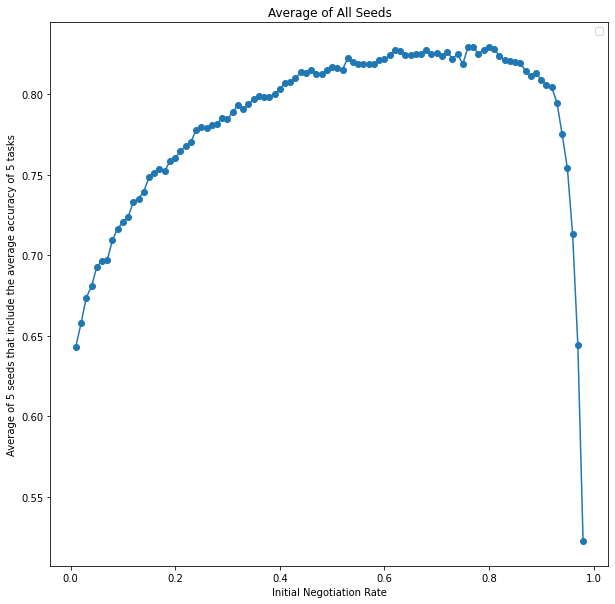

In [9]:
print(len(average_of_all_seeds_list))
#average_of_all_seeds_list

#in the main code initial_negotiation_rate_list gets affected by the number of seeds. (5 replicas for each element!)
#Instead Of fixing it in the main code I would rather redefine it here.
initial_negotiation_rate_list=list(range(1,99))
initial_negotiation_rate_list=[x*0.01 for x in initial_negotiation_rate_list]
print(len(initial_negotiation_rate_list))
import matplotlib.pyplot as plt

# Sample data
#average_of_all_seeds_list = [1, 2, 3, 4, 5]

# Creating x-axis values (assuming the list is to be plotted against indices)
x_values = list(range(len(average_of_all_seeds_list)))
# Set the figure size
plt.figure(figsize=(10, 10))

# Plotting the list
plt.plot(initial_negotiation_rate_list, average_of_all_seeds_list, marker='o', linestyle='-')

#plt.plot( average_of_all_seeds_list)
# Adding title and labels
plt.title('Average of All Seeds')
plt.xlabel('Initial Negotiation Rate')
plt.ylabel('Average of 5 seeds that include the average accuracy of 5 tasks')
plt.legend()
# Display the plot
plt.show()

In [ ]:
#initial_negotiation_rate_list=list(range(1,68))
#len(initial_negotiation_rate_list)